In [111]:
import itertools
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
from myst_nb import glue

from src.commons import NUM_EXPERIMENTS
from src.decorators import repeat, get_from_cache_or_run
from src.utils import build_plots_dir_path, build_cache_dir_path
from src.visualization import PLOT_DPI

plt.ioff()  # turn off interactive plotting
plt.style.use('../../../src/phd.mplstyle')

root_dir = pathlib.Path().cwd().parent.parent.parent
cwd_dir = pathlib.Path().cwd()

plot_dir = build_plots_dir_path(root_dir) / cwd_dir.name
cache_dir = build_cache_dir_path(root_dir) / cwd_dir.name

glue('num_experiments', NUM_EXPERIMENTS, display=False)

# Statistical verification of results

In order to assess significance and performance of obtained results two statistical approaches were used. The majority of metrics were compared using the Bayesian estimation (BEST) method {cite}`kruschke2013bayesian`, while the other straightforward metrics were just averaged.

## Bayesian analysis
The Bayesian approach towards comparing data from multiple groups was used instead of traditional methods of _null hypothesis significance testing_ (NHST). They are more intuitive than the calculation and interpretation of _p-value_ scores, provides complete information about credible parameter values and allow more coherent inferences from data {cite}`dienes2011bayesian`.

The perils of frequentist NHST approach when comparing machine learning classifiers were depicted by Benavoli in {cite}`benavoli2017time`, which is particularly suited for this work. He points the following reasons against using the NHST methods:
- it does not estimate probability of hypotheses,
- point-wise null hypothesis are practically always false,
- the p-value does not separate between the effect size and the sample size,
- it ignores magnitude and uncertainty,
- it yields no information about the null hypothesis,
- there is no principled way to decide the $\alpha$ level

Additionally, in 2016 the _[American Statistical Association](https://www.amstat.org/)_ made a statement against p-values {cite}`wasserstein2016asa` which might be a motivation for other disciplines to pursue the Bayesian approach.

````{margin}
```{admonition} T-distribution
The T distribution, like the normal distribution, is bell-shaped and symmetric, but it has heavier tails, which means it tends to produce values that fall far from its mean.

Tail heaviness is determined by a parameter called _degrees of freedom_ $\nu$ with smaller values giving heavier tails, and with higher values making the T distribution resemble a standard normal distribution with a mean of 0, and a standard deviation of 1.
```
````

In this work we focus on establishing a descriptive mathematical model of the data $D$ using the Equation {eq}`bayesian_approach`.

```{math}
:label: bayesian_approach
\underbrace{p(\mu, \sigma, \nu|D)}_{\text{posterior}} = \underbrace{p(D|\mu, \sigma, \nu)}_{\text{likelihood}} \times \underbrace{p(\mu, \sigma, \nu)}_{\text{prior}} \big/ \underbrace{p(D)}_{\text{evidence}}
```

Each experiment is performed {glue:}`num_experiments` times, generating independent samples, which according to the Central Limit Theorem, should be enough to consider it approximating the normal distribution {cite}`islam2018sample`. To further provide a robust solution towards dealing with potential outliers, the _Student t-distribution_ is chosen. The prior distribution, described with three parameters - $\mu$ (expected mean value), $\sigma$ (standard deviation) and $\nu$ (degrees of freedom) is presented using the Equation {eq}`bayesian_prior`.

```{math}
:label: bayesian_prior
\begin{align}
    \mu &\sim \mathrm{N}(\mu_D, \sigma^2_D) \\
    \sigma &\sim \mathrm{U}(\frac{1}{100}, 1000) \\
    \nu &\sim \mathrm{Exp}(\frac{1}{29})
\end{align}
```
The posterior distribution is approximated to arbitrarily high accuracy by generating a large representative sample from it using _Markov chain Monte Carlo_ (MCMC) methods. It's sample provides many thousands of combinations of parameter values $<\mu, \sigma, \nu>$. Each such combination of values is representative of credible parameter values that simultaneously accommodate the observed data and the prior distribution. From the MCMC sample, one can infer credible parameter values like the mean or standard deviation.

### Example
To show an example of this technique, the performance of an ACS2 algorithm operating in a multistep, toy-problem - Simple Maze environment {cite}`gerard2000yacs` (see Figure {numref}`{number} <simple-maze-env>`) will be discussed using three methods - the summary statistics, frequentist approach and the Bayesian estimation.

:::{figure-md} simple-maze-env
<img src="../../_static/simple-maze.png" width="75%">

The Simple Maze environment is a POMDP where the agent is placed in the starting location (denoted as "S"), at the beginning of each new trial, and the goal is to reach the final state "F" by executing four possible actions – moving north, east, south or west. The goal can be reached optimally in eight successive steps.
:::

In [112]:
import gym
import lcs.agents.acs2 as acs2

SIMPLE_MAZE_TRIALS = 500
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.8


def simple_maze_env_provider():
    import gym_yacs_simple_maze  # noqa: F401
    return gym.make('SimpleMaze-v0')


def custom_metrics(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'reliable': len([cl for cl in population if cl.is_reliable()])
    }


@get_from_cache_or_run(cache_path=f'{cache_dir}/simple-maze/acs2.dill')
@repeat(num_times=NUM_EXPERIMENTS, use_ray=True)
def run_acs2(env_provider):
    simple_maze_env = env_provider()

    cfg = acs2.Configuration(
        classifier_length=4,
        number_of_possible_actions=4,
        beta=LEARNING_RATE,
        gamma=DISCOUNT_FACTOR,
        do_ga=False,
        metrics_trial_frequency=1,
        user_metrics_collector_fcn=custom_metrics)

    agent = acs2.ACS2(cfg)
    return agent.explore(simple_maze_env, SIMPLE_MAZE_TRIALS)


@get_from_cache_or_run(cache_path=f'{cache_dir}/simple-maze/acs2ga.dill')
@repeat(num_times=NUM_EXPERIMENTS, use_ray=True)
def run_acs2ga(env_provider):
    simple_maze_env = env_provider()

    cfg = acs2.Configuration(
        classifier_length=4,
        number_of_possible_actions=4,
        beta=LEARNING_RATE,
        gamma=DISCOUNT_FACTOR,
        do_ga=True,
        metrics_trial_frequency=1,
        user_metrics_collector_fcn=custom_metrics)

    agent = acs2.ACS2(cfg)
    return agent.explore(simple_maze_env, SIMPLE_MAZE_TRIALS)


# run computations
acs2_runs_metrics = run_acs2(simple_maze_env_provider)
acs2ga_runs_metrics = run_acs2ga(simple_maze_env_provider)

# build dataframes
acs2_metrics_df = pd.DataFrame(itertools.chain(*acs2_runs_metrics))
acs2ga_metrics_df = pd.DataFrame(itertools.chain(*acs2ga_runs_metrics))

# extract population size in last trial
acs2_population_counts = acs2_metrics_df.query(f'trial == {SIMPLE_MAZE_TRIALS - 1}')['reliable']
acs2ga_population_counts = acs2ga_metrics_df.query(f'trial == {SIMPLE_MAZE_TRIALS - 1}')['reliable']

# glue variables
glue('stats_simple_maze_trials', SIMPLE_MAZE_TRIALS, display=False)

The ACS2 agent will be tested in two variants - with and without the genetic algorithm modification. All other settings are identical. Both agents in each experiment will execute {glue:}`stats_simple_maze_trials` trials, each time randomly selecting an action. Finally, each such experiment will be independently repeated {glue:}`num_experiments` times.

````{admonition} Null hypothesis
The classifier population sizes obtained by ACS2 and ACS2 GA in the last trial $x$ are equal
````

**Descriptive statistics**

First option is to understand the data and extract basic summary statistics. Figure {numref}`{number} <summary-stats>` presents a whisker plot showing basic data aggregations like the minimum, first quartile, median, third quartile, maximum values alongside the histogram visualization. While the values look similar it is still not clear whether they can be considered the same.


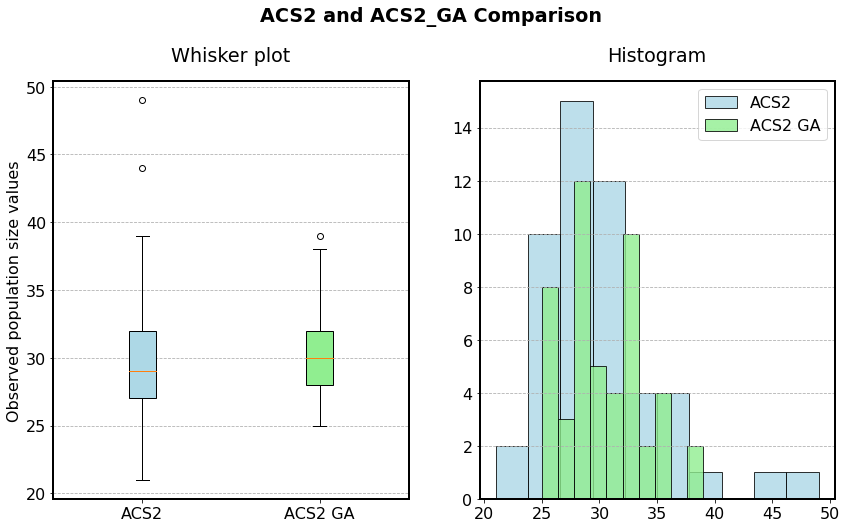

In [115]:
def plot_summary_statistics(data, labels, plot_filename=None):
    fig = plt.figure(figsize=(14, 8))
    colors = ['lightblue', 'lightgreen']

    # boxplot
    ax1 = fig.add_subplot(121)

    bp = ax1.boxplot(data,
                     patch_artist=True,
                     labels=labels)

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax1.set_title('Whisker plot', pad=20)
    ax1.set_ylabel('Observed population size values')
    ax1.grid(which='major', axis='y', linestyle='--')

    # histogram
    ax2 = fig.add_subplot(122)
    for d, l, c in zip(data, labels, colors):
        ax2.hist(d, bins=10, label=l, color=c, edgecolor='black', alpha=.8, linewidth=1)

    ax2.set_title('Histogram', pad=20)
    ax2.grid(which='major', axis='y', linestyle='--')
    ax2.legend()

    # common settings
    fig.suptitle('ACS2 and ACS2 GA Comparison', fontweight='bold')
    fig.subplots_adjust(top=0.85)

    if plot_filename:
        fig.savefig(plot_filename, dpi=PLOT_DPI)

    return fig


summary_plot_fig = plot_summary_statistics(
    [acs2_population_counts.to_numpy(), acs2ga_population_counts.to_numpy()],
    ['ACS2', 'ACS2 GA'],
    plot_filename=f'{plot_dir}/summary-stats.png')

:::{figure-md} summary-stats
:class: full-width
<img src="../../_static/plots/2_selected_topics/summary-stats.png" width="75%">

Descriptive statistics depicting population size obtained after executing two versions of the ACS2 agent in the Simple Maze environment.
:::

**Frequentist approach**

For the frequentist approach first two hypothesis about data distribution are formed:

```{math}
\begin{align*}
&H_0: \text{The classifier population sizes obtained by ACS2 and ACS2 GA are equal}\\
&H_1: \text{The classifier population sizes obtained by ACS2 and ACS2 GA are different}
\end{align*}
```

In traditional NHST workflow the first step would be to apply normality tests to verify whether the data is normally distributed. However, looking at the histograms from the Figure {numref}`{number} <summary-stats>` we might assume that the data follows the Gaussian distribution and skip this step.

If the $H_0$ hypothesis will be rejected it means that there is no significant difference between the means. To do so a p-value will be calculated and compared with certain threshold $\alpha \leq 0.05$. If the p-value fall below the threshold, it means that the null hypothesis $H_0$ can be rejected and **there is 95% confidence that both means are significantly different**.

In [120]:
from scipy.stats import ttest_ind

# don't assume equal variances
value, pvalue = ttest_ind(acs2_population_counts, acs2ga_population_counts, equal_var=False)

glue('stats-pvalue', round(pvalue, 2), display=False)

0.6793886029922142

In this case the after running the two-sided t-Test the calculated p-value is {glue:}`stats-pvalue` which indicates strong evidence for the $H_0$ hypothesis, meaning that it is retained. Keep in mind that NHST does not accept the null hypothesis, it can be only rejected or failed to be rejected. Stating that it is correct implies 100% certainty, which is not valid in this methodology.

**Bayesian estimation**

Throughout this work a [PyMC3](https://docs.pymc.io/en/v3/) open-sourced Python framework is used for the probabilistic programming. Figure {numref}`{number} <stats_bayes_params_fig>` depicts two separate Student-t posterior distribution hyper-parameters estimated by using the MCMC method.

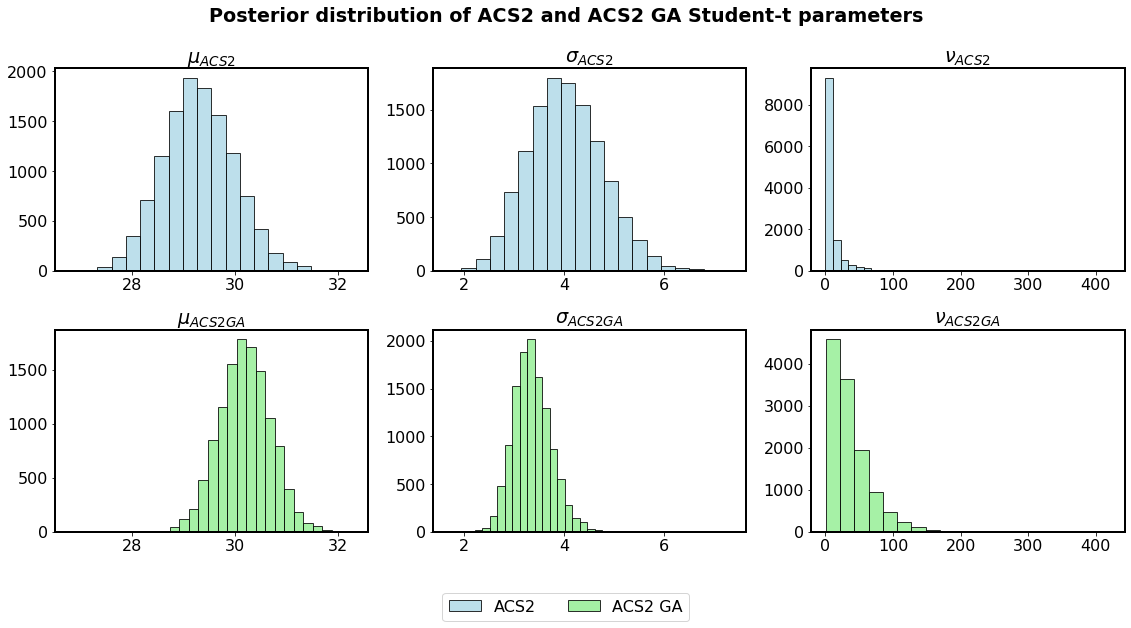

In [208]:
from src.bayes_estimation import bayes_estimate


@get_from_cache_or_run(cache_path=f'{cache_dir}/simple-maze/bayes-acs2.dill')
def bayes_estimate_acs2(data):
    return bayes_estimate(data)


@get_from_cache_or_run(cache_path=f'{cache_dir}/simple-maze/bayes-acs2ga.dill')
def bayes_estimate_acs2ga(data):
    return bayes_estimate(data)


# run estimations
bayes_acs2_trace = bayes_estimate_acs2(acs2_population_counts.to_numpy())
bayes_acs2ga_trace = bayes_estimate_acs2ga(acs2ga_population_counts.to_numpy())


def plot_bayes_parameters(data, labels, plot_filename=None):
    colors = ['lightblue', 'lightgreen']
    hist_kwargs = {'bins': 20, 'edgecolor': 'black', 'alpha': .8, 'linewidth': 1}

    fig, axs = plt.subplots(2, 3, figsize=(16, 8))

    for i, (d, l, c) in enumerate(zip(data, labels, colors)):
        axs[i][0].hist(d['mu'], color=c, label=l, **hist_kwargs)
        axs[i][0].set_title(f'$\mu_{{{l}}}$')

        axs[i][1].hist(d['std'], color=c, label=l, **hist_kwargs)
        axs[i][1].set_title(f'$\sigma_{{{l}}}$')

        axs[i][2].hist(d['nu'], color=c, label=l, **hist_kwargs)
        axs[i][2].set_title(fr'$\nu_{{{l}}}$')

    # share axes
    axs[0][0].sharex(axs[1][0])
    axs[0][1].sharex(axs[1][1])
    axs[0][2].sharex(axs[1][2])

    # common
    handles, labels = [(a + b) for a, b in zip(axs[0][0].get_legend_handles_labels(), axs[1][0].get_legend_handles_labels())]
    fig.suptitle('Posterior distribution of ACS2 and ACS2 GA Student-t parameters', fontweight='bold')
    fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))
    fig.tight_layout()

    if plot_filename:
        fig.savefig(plot_filename, dpi=PLOT_DPI)

    return fig


bayes_parameters_fig = plot_bayes_parameters(
    [bayes_acs2_trace, bayes_acs2ga_trace],
    ['ACS2', 'ACS2 GA'],
    plot_filename=f'{plot_dir}/stats-bayes-parameters.png')

glue('stats_bayes_params_fig', bayes_parameters_fig, display=False)

```{glue:figure} stats_bayes_params_fig
:name: "stats_bayes_params_fig"
Parameter distributions of Student-t estimation of population size data for two agents.
```

Describe the usage of the ROPE intervals to inference about the data.

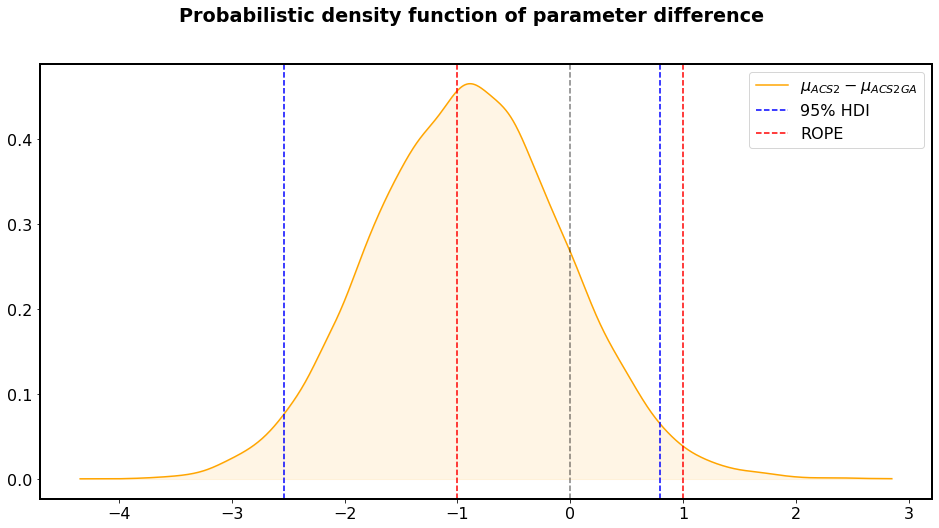

In [237]:
import arviz
import numpy as np
from scipy.stats import gaussian_kde

def plot_kde(data_diff, rope=None, hdi_prob=0.95, plot_filename=None):
    if rope is None:
        rope = [-1, 1]

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111)

    x = np.linspace(min(data_diff), max(data_diff), 1000)
    gkde = gaussian_kde(data_diff)
    ax.plot(x, gkde(x), color='orange', label='$\mu_{ACS2}-\mu_{ACS2GA}$')
    ax.fill_between(x, gkde(x), alpha=0.1, color='orange')

    # no difference vertical line
    ax.axvline(0, color='black', alpha=0.5, linestyle='--')

    # high density interval
    hdi = arviz.hdi(data_diff, hdi_prob=0.95)
    ax.axvline(x=hdi[0], linestyle='--', color='blue', label=f'{int(hdi_prob * 100)}% HDI')
    ax.axvline(x=hdi[1], linestyle='--', color='blue')

    # ROPE
    ax.axvline(x=rope[0], linestyle='--', color='red', label='ROPE')
    ax.axvline(x=rope[1], linestyle='--', color='red')

    fig.suptitle('Probabilistic density function of parameter difference', fontweight='bold')

    plt.legend()

    if plot_filename:
        fig.savefig(plot_filename, dpi=PLOT_DPI)

    return fig


data_diff = bayes_acs2_trace['mu'] - bayes_acs2ga_trace['mu']
plot_kde(data_diff)